In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode, VOID
from micrograd.eval import feed_forward, calc_sq_loss, calc_accuracy, evaluate
from micrograd.visualize import draw_dot

%matplotlib inline

In [10]:
np.random.seed(1337)
random.seed(1337)

CLASSES = [0, 1]
oh_encoder, oh_decoder = oh_encode(CLASSES)

x = torch.tensor([
    [1, 0]
])
y_oh = oh_encoder([0])

model = MLP(
    [
        Layer(
            [x.shape[1], y_oh.shape[1]],
            'sbin',
            lr=1.0,
            _lid=0,
            init=lambda: round(random.uniform(-1,1)), # TODO: play with initial value
            bias=False,
        )
    ]
)
model.norm()


input = arr2vals(x, 'input')
scores = feed_forward(model, input)
targets = arr2vals(y_oh, 'target')

print('inputs: ', x)
print('targets: ', y_oh, '\n')

total_loss = calc_sq_loss(scores, targets)

def dump(k, model, total_loss=None, scores=None):
    print(f'{k} params: ', model.layers[0].parameters())
    if total_loss:
        print(f'{k} loss: ', total_loss)
    if scores:
        print(f'{k} scores: ', scores, '\n')

inputs:  tensor([[1, 0]])
targets:  tensor([[ 1., -1.]]) 



backward:loss:[grad <- 1]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5]
backward:auto:[grad <- 1.0]
backward:neg-target:0:1:[grad <- 1.0]
backward:-1:[grad <- -1.0]
backward:target:0:1:[grad <- -1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:L0:n1:w1:[grad <- 0.0]
backward:auto:[grad <- 1.0]
backward:L0:n1:w0:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5]
backward:auto:[grad <- -1.0]
backward:neg-target:0:0:[grad <- -1.0]
backward:-1:[grad <- -1.0]
backward:target:0:0:[grad <- 1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:input:0:1:[grad <- 0.0]
backward:L0:n0:w1:[grad <- 0.0]
backward:auto:[grad <- -1.0]
backward:input:0:0:[grad <- 0.0]
backward:L0:n0:w0:[grad <- -1.0]
backward:init loss:[grad <- 1.0]
backward:init loss:[grad <- 1.0]


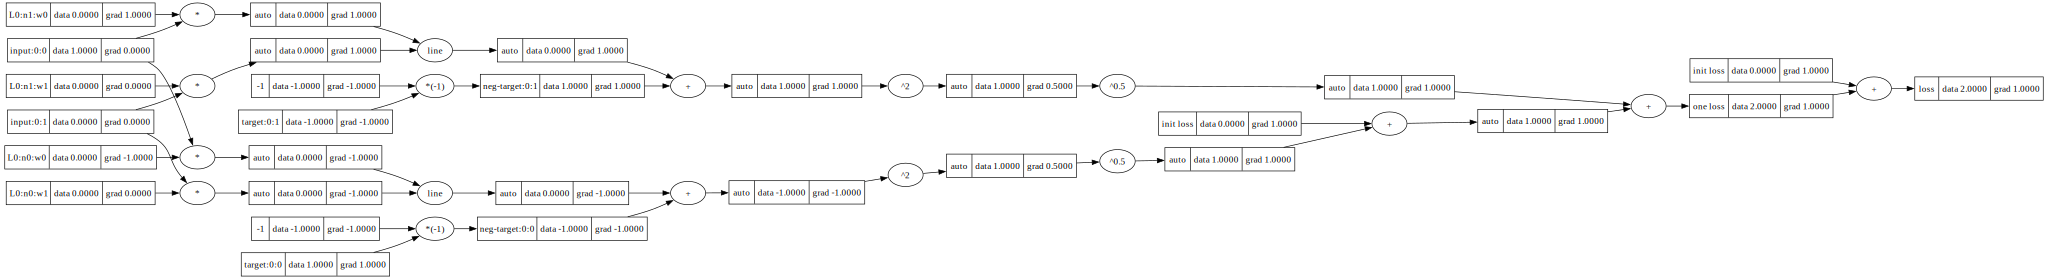

In [11]:
total_loss.backward(logging=True)
draw_dot(total_loss)

accuracy:  0.0


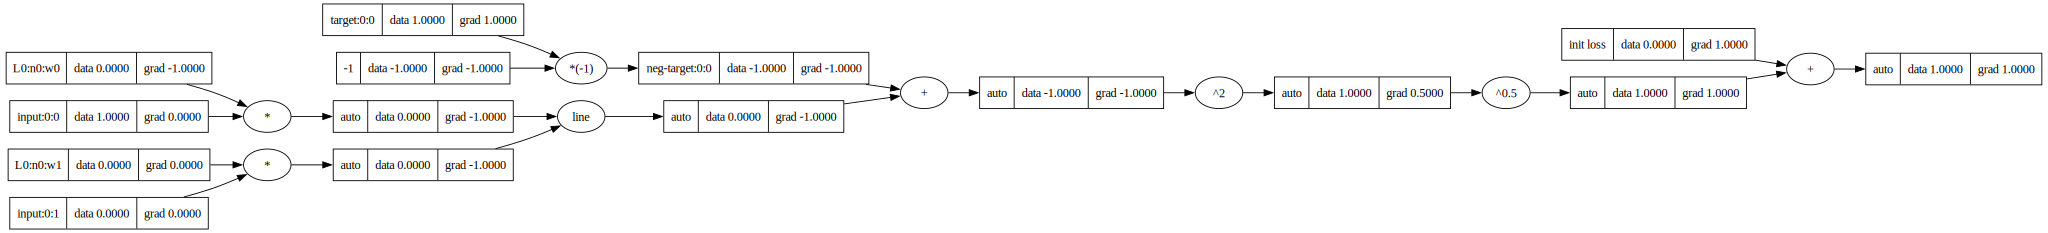

In [13]:
scores = feed_forward(model, input)
acc = calc_accuracy(scores, targets, oh_decoder)
print('accuracy: ', acc)
draw_dot(total_loss.child(1).child(0))

In [14]:
def learn_some(model, total_loss=None, iterations=1, logging=True, norm=False, q=1.0):
    dump('start', model)

    for k in range(iterations):
        if total_loss is not None:
            model.learn_from(total_loss, logging=logging, norm=norm, q=q)

        scores = feed_forward(model, input)
        total_loss = calc_sq_loss(scores, targets)

        dump(k, model, total_loss, scores)

    acc = calc_accuracy(scores, targets, oh_decoder)
    print(f'accuracy: {acc}')
    return total_loss, scores

start params:  [Value(L0:n0:w0 : [0.0, -1.0, 1.0]), Value(L0:n0:w1 : [0.0, 0.0, 1.0]), Value(L0:n1:w0 : [0.0, 1.0, 1.0]), Value(L0:n1:w1 : [0.0, 0.0, 1.0])]
backward:loss:[grad <- 1]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5]
backward:auto:[grad <- 1.0]
backward:neg-target:0:1:[grad <- 1.0]
backward:-1:[grad <- -1.0]
backward:target:0:1:[grad <- -1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:L0:n1:w1:[grad <- 0.0]
backward:auto:[grad <- 1.0]
backward:L0:n1:w0:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.5]
backward:auto:[grad <- -1.0]
backward:neg-target:0:0:[grad <- -1.0]
backward:-1:[grad <- -1.0]
backward:target:0:0:[grad <- 1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:input:0:1:[grad <- 0.0]
backward:L0:n0:w1:[grad <- 0.0]
backward:auto:[grad <- -1.0]
backward:input:0:0:[grad <- 0.0]
backward:L0:n0:w0:[grad <- -1.0]
backward:init loss:[gr

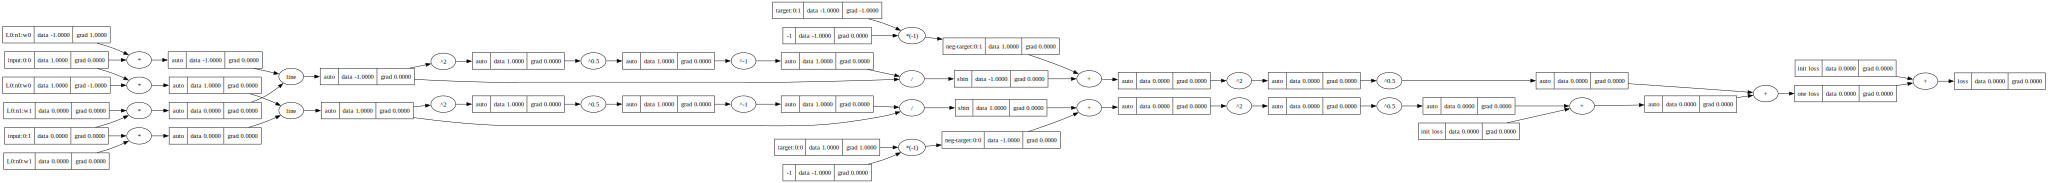

In [6]:
total_loss, scores = learn_some(model, total_loss, norm=True)
draw_dot(total_loss)

backward:loss:[grad <- 1]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:neg-target:0:1:[grad <- 0.0]
backward:-1:[grad <- 0.0]
backward:target:0:1:[grad <- 0.0]
backward:sbin:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:L0:n1:w1:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:L0:n1:w0:[grad <- 0.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:neg-target:0:0:[grad <- 0.0]
backward:-1:[grad <- 0.0]
backward:target:0:0:[grad <- 0.0]
backward:sbin:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:input:0:1:[grad <- 0.0]
backward:L0:n0:w1:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:input:0:0:[grad <- 0

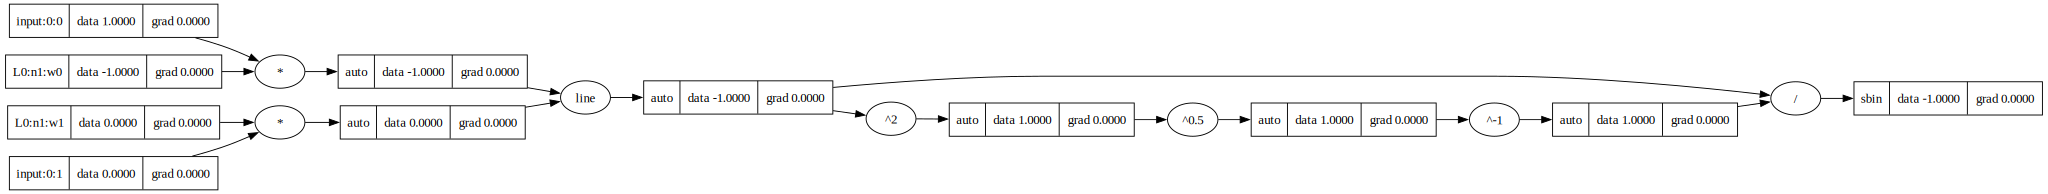

In [7]:
scores = feed_forward(model, input)
total_loss = calc_sq_loss(scores, targets)
total_loss.backward(logging=True)
print(f'loss: {total_loss.data}')
draw_dot(scores[0][1])

start params:  [Value(L0:n0:w0 : [1.0, 0.0, 1.0]), Value(L0:n0:w1 : [0.0, 0.0, 1.0]), Value(L0:n1:w0 : [-1.0, 0.0, 1.0]), Value(L0:n1:w1 : [0.0, 0.0, 1.0])]
backward:loss:[grad <- 1]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:neg-target:0:1:[grad <- 0.0]
backward:-1:[grad <- 0.0]
backward:target:0:1:[grad <- 0.0]
backward:sbin:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:L0:n1:w1:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:L0:n1:w0:[grad <- 0.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:neg-target:0:0:[grad <- 0.0]
backward:-1:[grad <- 0.0]
backward:target:0:0:[grad <- 0.0]
backward:sbin:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:auto:[grad <

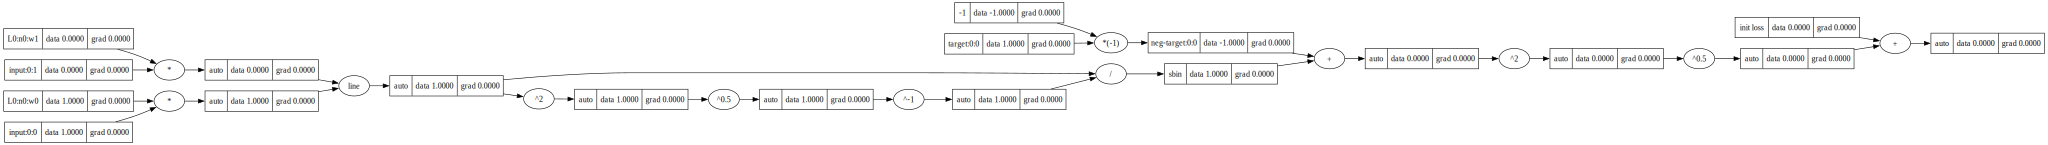

In [8]:
total_loss, scores = learn_some(model, total_loss, 1, norm=True, q=1.0, logging=True)
draw_dot(total_loss.child(1).child(0))